would like to model $Y^a(X)$

$Y^a(X) = \phi(X)^T\beta^a$ and $\beta^a \sim \mathcal{N}(0,\Sigma_\beta)$

$\phi(X)$: A basis function mapping the features X to a higher-dimensional space, capturing interactions, non-linearities, etc. 

$\beta^a$ : A treatment-specific parameter vector with a Gaussian prior, which allows for probabilistic modeling of potential outcomes for treatment a. 

$Y^a(X)$: The modeled potential outcome for treatment 𝑎 a and feature vector X.

**Posterior Distribution**
given observed data $D_a = (X_i, Y_i, A_i = a)$. 

Posterior becomes
$$\beta^a \mid data \sim \mathcal{N}(\hat{\beta}^a,\Sigma_\beta)$$

Then, 
$$Y^a(X) \mid data \sim \mathcal{N}(\phi(X)^T\beta^a, \phi(X)^T\Sigma_\beta\phi(X))$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### generate covariate and ground truth outcome model

In [2]:
def covariate_model(n):
    """
    Generates a covariate matrix with n rows and 2 columns, 
    where each element is drawn from a uniform distribution between 0 and 1.
    """
    return np.random.uniform(0, 1, size=(n, 2))

def outcome_model(x, a, sd=0):
    """
    Generates the outcome based on covariates x, treatment indicator a, and noise sd.
    
    x: A 1D numpy array with two elements (features).
    a: Treatment indicator (0 or 1).
    sd: Standard deviation of random noise added to the outcome.
    """
    # Extract the covariates
    x1, x2 = x[0], x[1]

    # Compute the outcome
    outcome = (
        3/4 * np.exp(-1/4 * (9 * x1 - 2)**2 - 1/4 * (9 * x2 - 2)**2)
        + 3/4 * np.exp(-1/49 * (9 * x1 + 1)**2 - 1/10 * (9 * x2 + 1)**2)
        + 1/2 * a * np.exp(-1/4 * (9 * x1 - 7)**2 - 1/4 * (9 * x2 - 3)**2)
        - 1/5 * a * np.exp(-(9 * x1 - 4)**2 - (9 * x2 - 7)**2)
        + np.random.normal(0, sd)
    )

    return outcome

### figure plotting function

In [3]:
def plot_heatmaps_side_by_side(data1, title1, data2, title2, x1, x2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create side-by-side subplots
    levels = 100  # Number of contour levels
    
    # Plot the first heatmap
    c1 = axes[0].contourf(x1, x2, data1, levels=levels, cmap="viridis")
    fig.colorbar(c1, ax=axes[0], label="Value")
    axes[0].set_xlabel("X1")
    axes[0].set_ylabel("X2")
    axes[0].set_title(title1)
    
    # Plot the second heatmap
    c2 = axes[1].contourf(x1, x2, data2, levels=levels, cmap="viridis")
    fig.colorbar(c2, ax=axes[1], label="Value")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")
    axes[1].set_title(title2)
    
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

In [4]:
def plot_residuals(residuals_0, residuals_1):
    # Plot residual distribution for control group
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(residuals_0, bins=30, alpha=0.7, label="Residuals (Control)")
    plt.axvline(0, color='red', linestyle='--', label="Zero Line")
    plt.title("Residual Distribution (Control Group)")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.legend()

    # Plot residual distribution for treatment group
    plt.subplot(1, 2, 2)
    plt.hist(residuals_1, bins=30, alpha=0.7, label="Residuals (Treatment)")
    plt.axvline(0, color='red', linestyle='--', label="Zero Line")
    plt.title("Residual Distribution (Treatment Group)")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.legend()

    plt.tight_layout()
    plt.show()

### plot potential outcome heatmap

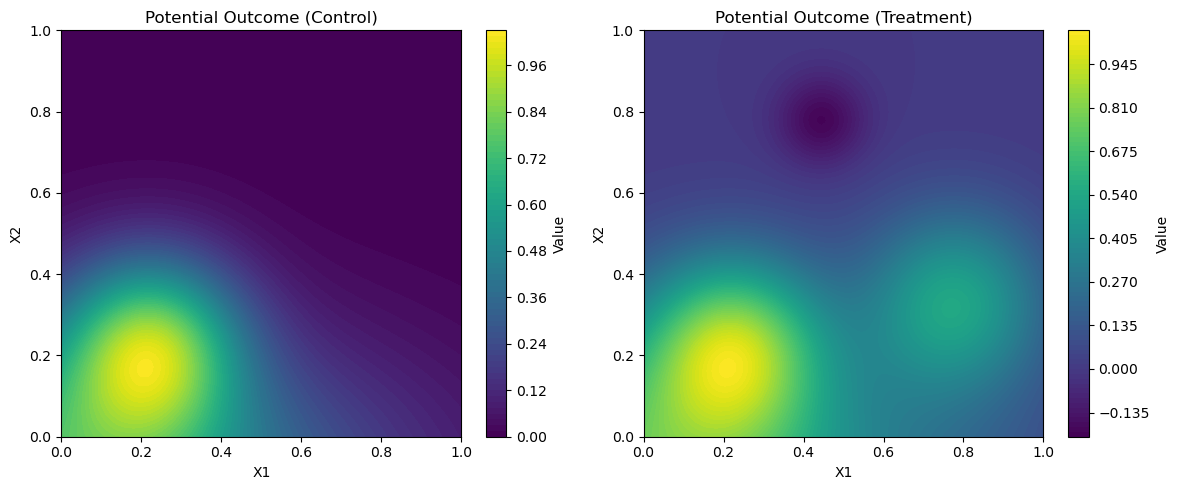

In [5]:
# Generate a grid of covariates
x1 = np.linspace(0, 1, 100)  # Range of first covariate
x2 = np.linspace(0, 1, 100)  # Range of second covariate
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])  # Flatten grid into array

# Predict potential outcomes
Y_0_grid = outcome_model(X_grid.T, 0, sd=0).reshape(X1.shape)
Y_1_grid = outcome_model(X_grid.T, 1, sd=0).reshape(X1.shape)

# Reshape predictions for plotting
Y_0_heatmap = Y_0_grid.reshape(X1.shape)
Y_1_heatmap = Y_1_grid.reshape(X1.shape)

# Plot the heatmaps side by side
plot_heatmaps_side_by_side(Y_0_grid, "Potential Outcome (Control)", Y_1_grid, "Potential Outcome (Treatment)", X1, X2)

### **Fit a model for $\beta^a$**

$$
\hat{\beta}^{(a)} = (\Phi_a^\top \Phi_a + \lambda I)^{-1} \Phi_a^\top Y_a,
$$
where:
- $\Phi_a$ is the transformed covariate matrix for treatment $a$.
- $Y_a$ is the observed outcomes for treatment $a$.
- $\lambda$ is a regularization parameter, ridge


### Polynomial Expansion

For $X = [x_1, x_2, \dots, x_n]$

$d = 2$: $x_1^2, x_1 x_2, x_2^2, \dots$

In [6]:
from sklearn.preprocessing import PolynomialFeatures

def phi_polynomial(X, degree=2):
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(X)

In [7]:
n_train = 500

# Simulated training data
X_train = covariate_model(n_train)
A_train = np.random.choice([0, 1], size=n_train)  # Random treatment assignment
Y_train = np.array([outcome_model(x, a) for x, a in zip(X_train, A_train)])

# Partition data by treatment
X_train_0 = X_train[A_train == 0]
Y_train_0 = Y_train[A_train == 0]
X_train_1 = X_train[A_train == 1]
Y_train_1 = Y_train[A_train == 1]

In [8]:
from sklearn.linear_model import Ridge

d = 20

# Transform covariates
Phi_0 = phi_polynomial(X_train_0, d)
Phi_1 = phi_polynomial(X_train_1, d)

# Fit models for each treatment
model_0 = Ridge(alpha=1.0).fit(Phi_0, Y_train_0) 
model_1 = Ridge(alpha=1.0).fit(Phi_1, Y_train_1)

In [9]:
def predict_model_0(X_new, degree):
    Phi_new = phi_polynomial(X_new, degree=degree)
    Y_0 = model_0.predict(Phi_new)
    return Y_0

def predict_model_1(X_new, degree):
    Phi_new = phi_polynomial(X_new, degree=degree)
    Y_1 = model_1.predict(Phi_new)
    return Y_1

In [10]:
X_test = covariate_model(1000)

# Compute ground truth potential outcomes and ITE
Y_0_true = np.array([outcome_model(x, 0) for x in X_test])
Y_1_true = np.array([outcome_model(x, 1) for x in X_test])
ITE_true = Y_1_true - Y_0_true

# Compute predictions
Y_0_pred = predict_model_0(X_test, d)
Y_1_pred = predict_model_1(X_test, d)

# Compute evaluation metrics
mse_0 = np.mean((Y_0_pred - Y_0_true) ** 2)
mse_1 = np.mean((Y_1_pred - Y_1_true) ** 2)

print(f"MSE (Control): {mse_0}")
print(f"MSE (Treatment): {mse_1}")

MSE (Control): 0.012277973481661932
MSE (Treatment): 0.012769877908036692


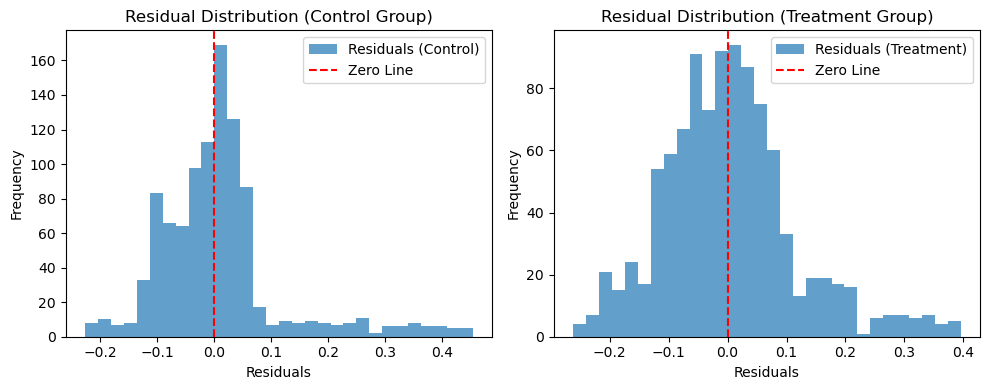

In [11]:
# Compute residuals
residuals_0 = Y_0_true - Y_0_pred
residuals_1 = Y_1_true - Y_1_pred

plot_residuals(residuals_0, residuals_1)

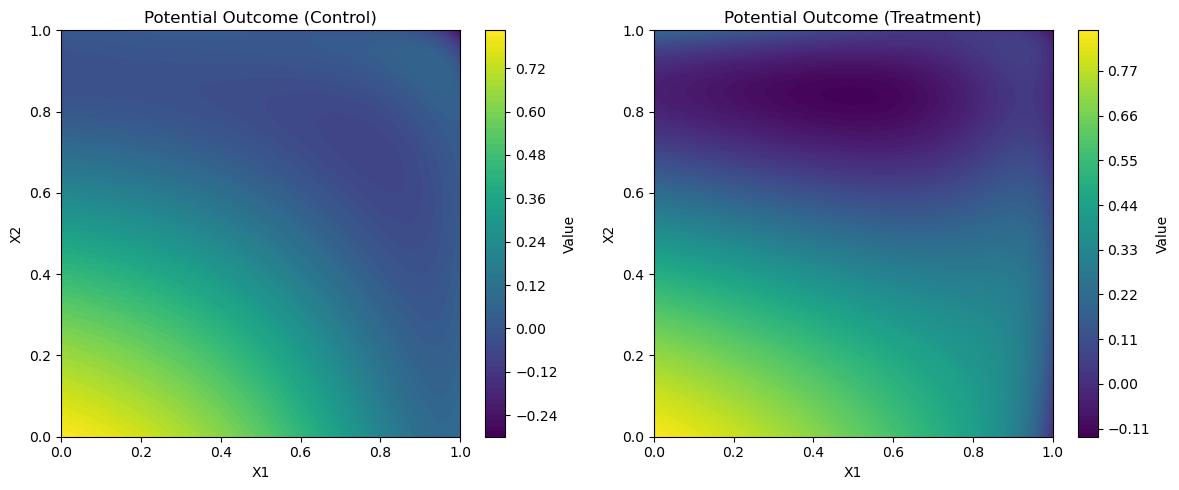

In [12]:
# Generate a grid of covariates
x1 = np.linspace(0, 1, 100)  # Range of first covariate
x2 = np.linspace(0, 1, 100)  # Range of second covariate
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])  # Flatten grid into array

# Predict potential outcomes
Y_0_grid = predict_model_0(X_grid, d).reshape(X1.shape)
Y_1_grid = predict_model_1(X_grid, d).reshape(X1.shape)

# Reshape predictions for plotting
Y_0_heatmap = Y_0_grid.reshape(X1.shape)
Y_1_heatmap = Y_1_grid.reshape(X1.shape)

# Plot the heatmaps side by side
plot_heatmaps_side_by_side(Y_0_grid, "Potential Outcome (Control)", Y_1_grid, "Potential Outcome (Treatment)", X1, X2)

### **Radial Basis Function (RBF)**

Radial Basis Function (RBF) kernel for a set of data points $X$ and a set of centers, given a parameter $\sigma$.

Each element $(i, j)$ in the resulting matrix is computed as:
     $$
     \text{RBF}(X_i, \text{center}_j) = \exp\left(-\frac{\|X_i - \text{center}_j\|^2}{2\sigma^2}\right)
     $$
   where $\|X_i - \text{center}_j\|^2$ is the squared Euclidean distance between the $i$-th point in $X$ and the $j$-th center.

RBF kernel implicitly maps the data to a higher-dimensional feature space where linear models can be applied effectively.


In [13]:
from sklearn.gaussian_process.kernels import RBF

def phi_rbf(X, centers, sigma):
    return np.exp(-np.sum((X[:, None, :] - centers[None, :, :]) ** 2, axis=2) / (2 * sigma ** 2))

In [14]:
n_train = 500

# Simulated training data
X_train = covariate_model(n_train)
A_train = np.random.choice([0, 1], size=n_train)  # Random treatment assignment
Y_train = np.array([outcome_model(x, a) for x, a in zip(X_train, A_train)])

# Partition data by treatment
X_train_0 = X_train[A_train == 0]
Y_train_0 = Y_train[A_train == 0]
X_train_1 = X_train[A_train == 1]
Y_train_1 = Y_train[A_train == 1]

In [15]:
## project data to a higher dimensional space
Phi_0_rbf = phi_rbf(X_train_0, X_train_0, sigma=0.1)
Phi_1_rbf = phi_rbf(X_train_1, X_train_1, sigma=0.1)

model_0_rbf = Ridge(alpha=1.0).fit(Phi_0_rbf, Y_train_0)
model_1_rbf = Ridge(alpha=1.0).fit(Phi_1_rbf, Y_train_1)

def predict_model_0_rbf(X_new):
    Phi_new = phi_rbf(X_new, X_train_0, sigma=0.1)
    Y_0 = model_0_rbf.predict(Phi_new)
    return Y_0

def predict_model_1_rbf(X_new):
    Phi_new = phi_rbf(X_new, X_train_1, sigma=0.1)
    Y_1 = model_1_rbf.predict(Phi_new)
    return Y_1

In [16]:
X_test = covariate_model(1000)

# Compute ground truth potential outcomes and ITE
Y_0_true = np.array([outcome_model(x, 0) for x in X_test])
Y_1_true = np.array([outcome_model(x, 1) for x in X_test])

# Compute predictions
Y_0_pred_rbf = predict_model_0_rbf(X_test)
Y_1_pred_rbf = predict_model_1_rbf(X_test)

# Compute evaluation metrics
mse_0_rbf = np.mean((Y_0_pred_rbf - Y_0_true) ** 2)
mse_1_rbf = np.mean((Y_1_pred_rbf - Y_1_true) ** 2)

print(f"MSE (Control): {mse_0_rbf}")
print(f"MSE (Treatment): {mse_1_rbf}")

MSE (Control): 0.0007085522893692903
MSE (Treatment): 0.0006397836377985823


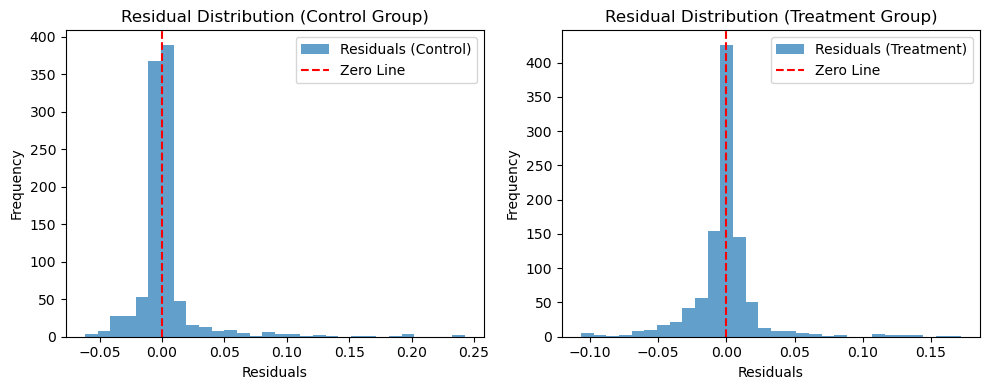

In [17]:
# Compute residuals
residuals_0_rbf = Y_0_true - Y_0_pred_rbf
residuals_1_rbf = Y_1_true - Y_1_pred_rbf

# Plot residual distribution for control group
plot_residuals(residuals_0_rbf, residuals_1_rbf)

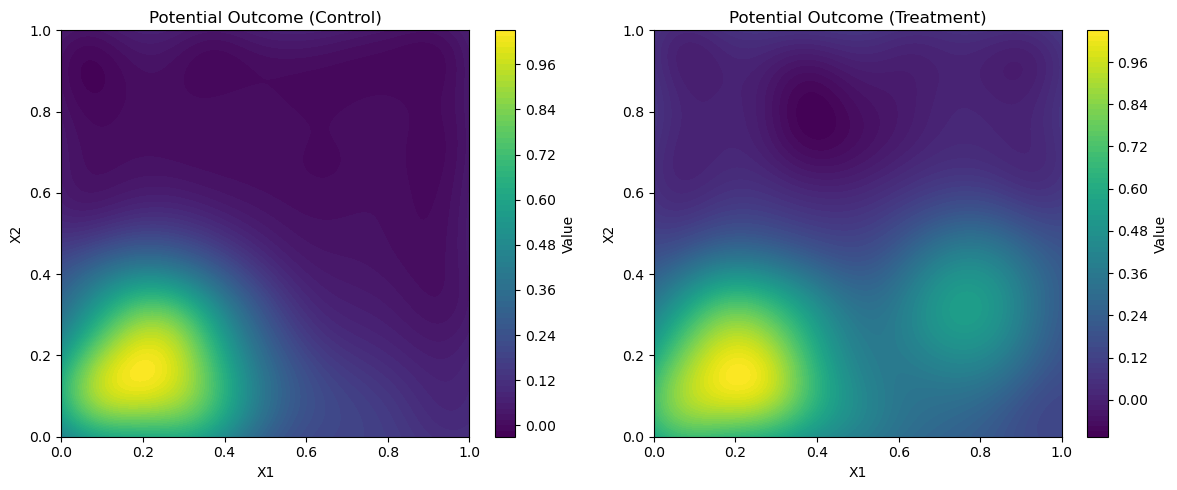

In [18]:
# Generate a grid of covariates
x1 = np.linspace(0, 1, 100)  # Range of first covariate
x2 = np.linspace(0, 1, 100)  # Range of second covariate
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])  # Flatten grid into array

# Predict potential outcomes
Y_0_grid = predict_model_0_rbf(X_grid).reshape(X1.shape)
Y_1_grid = predict_model_1_rbf(X_grid).reshape(X1.shape)

# Reshape predictions for plotting
Y_0_heatmap = Y_0_grid.reshape(X1.shape)
Y_1_heatmap = Y_1_grid.reshape(X1.shape)

plot_heatmaps_side_by_side(Y_0_grid, "Potential Outcome (Control)", Y_1_grid, "Potential Outcome (Treatment)", X1, X2)